# The sBG model for Customer Lifetime Value modeling

## Introduction for the discrete-time contractual setting

The sBG (or shifted Beta Geometric) model is relevant for the discrete-time, contractual setting. Subscription services clearly fall into this class as a fixed payment is taken at regular intervals, such as monthly or annually. Specific examples would include gym membership, Netflix, Disney+, Apple Music, Spotify, Amazon subscribe-and-save, union membership fees (for those of is in Europe ;), 

There are other discrete-time contractual examples which are slightly more complex however, which are not suitable for the vanilla sBG model. For example, Amazon Prime is at first sight a discrete-time contractual case, but the thing that makes this more complex is that Amazon Prime customers also make purchases, and these are maybe best described as continuous and non-contractual. Another example might be an Audible subscription where there is a regular fee for membership but customers then pay additional fees to access individual books. These more complex cases are _not_ within the scope of the sBG model as we present it here.

## Background of the sBG model
[DETAILS OF THE sBG MODEL AND REFERENCES]

## Understanding the sBG model
We have a single cohort of number of customers over time. The _raw_ data of number of customers might look like this.

    n = [100.0, 80.0, 64.0, 51.0, 41.0, 33.0, 26.0, 21.0]
    
It will become clear later, but it makes sense to calculate the observed churn in each time step. That is, how many people cancelled their subscription in a given time step. So we would end up with $churn =n_t - n_{t+1}$.

    churned = [20., 16., 13., 10.,  8.,  7.,  5., UNOBSERVED]

So for all time steps prior to the current one $T$, we have observed how many people have churned. But in the final time step we do not yet know how many people will enter into the next time step, so the number of churns in the final time step is unobserved.

So this is EITHER TRUNCATION OR CENSORING ????????????

## The log likelihood

The log likelihood is defined as:

$$
LL(\theta | \text{data}) = 
\underbrace{\sum_{t=1}^{T-1} \Big[ \overbrace{n_t - n_{t+1}}^{\text{number churned}} \cdot \ln [P(T=t|\theta)] \Big]}_{\text{all previous time periods}} + 
\underbrace{n_T \cdot \ln[S(T|\theta)]}_{\text{current time period}}
$$

where
- $\text{data} = n_1, n_2, \dots , n_T$ which is the number of customers remaining in the cohort
- $\theta$ is the churn rate
- so $1-\theta$ is the retention rate

The first term, with the sum covers all the time steps where we have observed number of churns:
- $churned_t = (n_t - n_{t+1})$ is the number of people who've churned (cancelled their contract) during time $t$.
- $P(T=t|\theta) = \theta(1-\theta)^{t-1}$ is the probability of churning on time step $t$ and is the product of not having churned up to now and the probability of churning in a given time step. This is the 'shifted' Geometric distribution.

The second term deals with the last time step. We do not know how many people have churned. But we do know how many people from this cohort have survived up to this point, i.e. the number who still have a subscription in the current time step.
- $S(T|\theta) = (1-\theta)^T$ is the survival function, so the probability of surviving up until time $T$.

So what we have is:

$$
LL(\theta | \text{data}) =  \sum_{t=1}^{T-1} \Big[ (n_t - n_{t+1}) \cdot \ln [\theta(1-\theta)^{t-1}] \Big]
+ n_T \cdot \ln[(1-\theta)^T]
$$

but we can take the exponents outside of the $\log$'s to be more numerically stable:

$$
LL(\theta | \text{data}) = \sum_{t=1}^{T-1} \Big[ (n_t - n_{t+1}) \cdot [ \ln(\theta) + (t-1) \cdot (1-\theta)] \Big]
+ n_T \cdot T \cdot \ln[1-\theta]
$$

## The sBG as a probabilistic model, for a single cohort

We can describe a probabilistic sBG model (for a single cohort) simply by taking the log likelihood we explored above, and adding a prior over the churn rate parameter $\theta$.

$$
\begin{aligned}
\theta & \sim \text{Binomial}(1, 1) \\
\vec{n} & \sim \text{TruncatedGeometric}(\theta)
\end{aligned}
$$

In [1]:
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from custom_distributions import truncated_geometric

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 6]

In [3]:
%load_ext autoreload
%autoreload 2

## Simulate data

In [4]:
# true churn rate per time step
θtrue = 0.35

# number of time steps to simulate
T = 8

In [5]:
times = np.arange(start=1, stop=T+1)
times

array([1, 2, 3, 4, 5, 6, 7, 8])

In [6]:
# simulate data
data = np.array([np.round(100*((1-θtrue)**(t-1))) for t in times])
data

array([100.,  65.,  42.,  27.,  18.,  12.,   8.,   5.])

## A single cohort sBG model in PyMC

In [7]:
with pm.Model() as sBG_single_cohort:
    θ = pm.Beta('θ', 1, 1)
    truncated_geometric('cohort1', data, θ)

In [8]:
with sBG_single_cohort:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


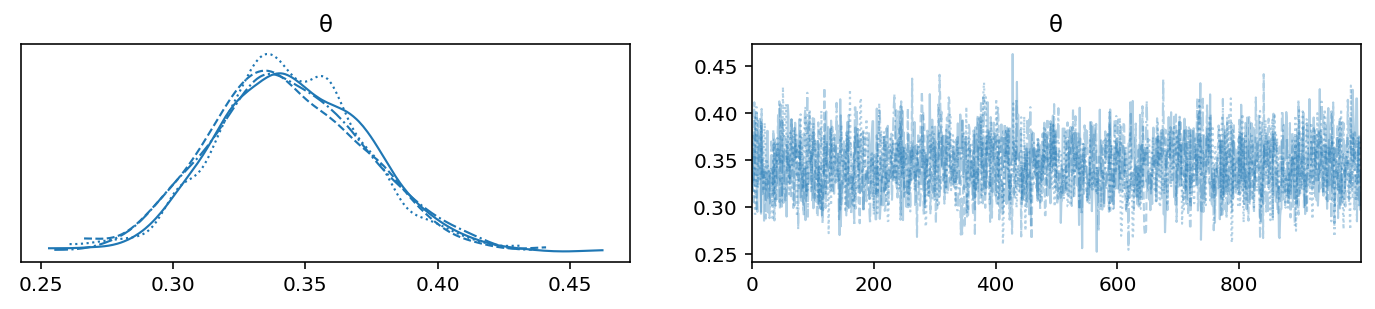

In [9]:
az.plot_trace(idata);

## A multiple cohort sBG model in PyMC

It is pretty simple to extend what we have done to deal with multiple cohorts.

One of the main differences is that we do not just have a vector of customer counts $\vec{n}$ for a single cohort, but we will now have a list of many. So if we have $C$ cohorts then our observed numbers of cusomers are $[\vec{n_1}, \vec{n_2}, \ldots , \vec{n_C} ]$.

Remember we still have just a single churn rate parameter $\theta$ for all people in all cohorts.

TODO: This needs to be improved! Maybe we can consider some kind of multivariate version of the custom distribution? Or one that operates on lists of vectors?

$$
\begin{aligned}
\theta & \sim \text{Binomial}(1, 1) \\
\vec{n_1}, \vec{n_2}, \ldots , \vec{n_C} & \sim \text{TruncatedGeometric}(\theta)
\end{aligned}
$$

In [10]:
# true churn rate per time step
θtrue = 0.35

# number of time steps to simulate
T = 8

data = []
for n_obs in np.arange(T)+2:
    times = np.arange(start=1, stop=n_obs+1)
    data.append(np.array([np.round(100*((1-θtrue)**(t-1))) for t in times]))
    
data

[array([100.,  65.]),
 array([100.,  65.,  42.]),
 array([100.,  65.,  42.,  27.]),
 array([100.,  65.,  42.,  27.,  18.]),
 array([100.,  65.,  42.,  27.,  18.,  12.]),
 array([100.,  65.,  42.,  27.,  18.,  12.,   8.]),
 array([100.,  65.,  42.,  27.,  18.,  12.,   8.,   5.]),
 array([100.,  65.,  42.,  27.,  18.,  12.,   8.,   5.,   3.])]

In [11]:
with pm.Model() as sBG_multiple_cohort:
    α = pm.Gamma('α', alpha=1, beta=1)
    β = pm.Gamma('β', alpha=1, beta=1)
    θ = pm.Beta('θ', α, β)
    for i, cohort_data in enumerate(data):
        truncated_geometric(f"cohort{i}", cohort_data, θ)
    
# pm.model_to_graphviz(sBG_multiple_cohort)

In [12]:
with sBG_multiple_cohort:
    idata = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymmmc_env/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


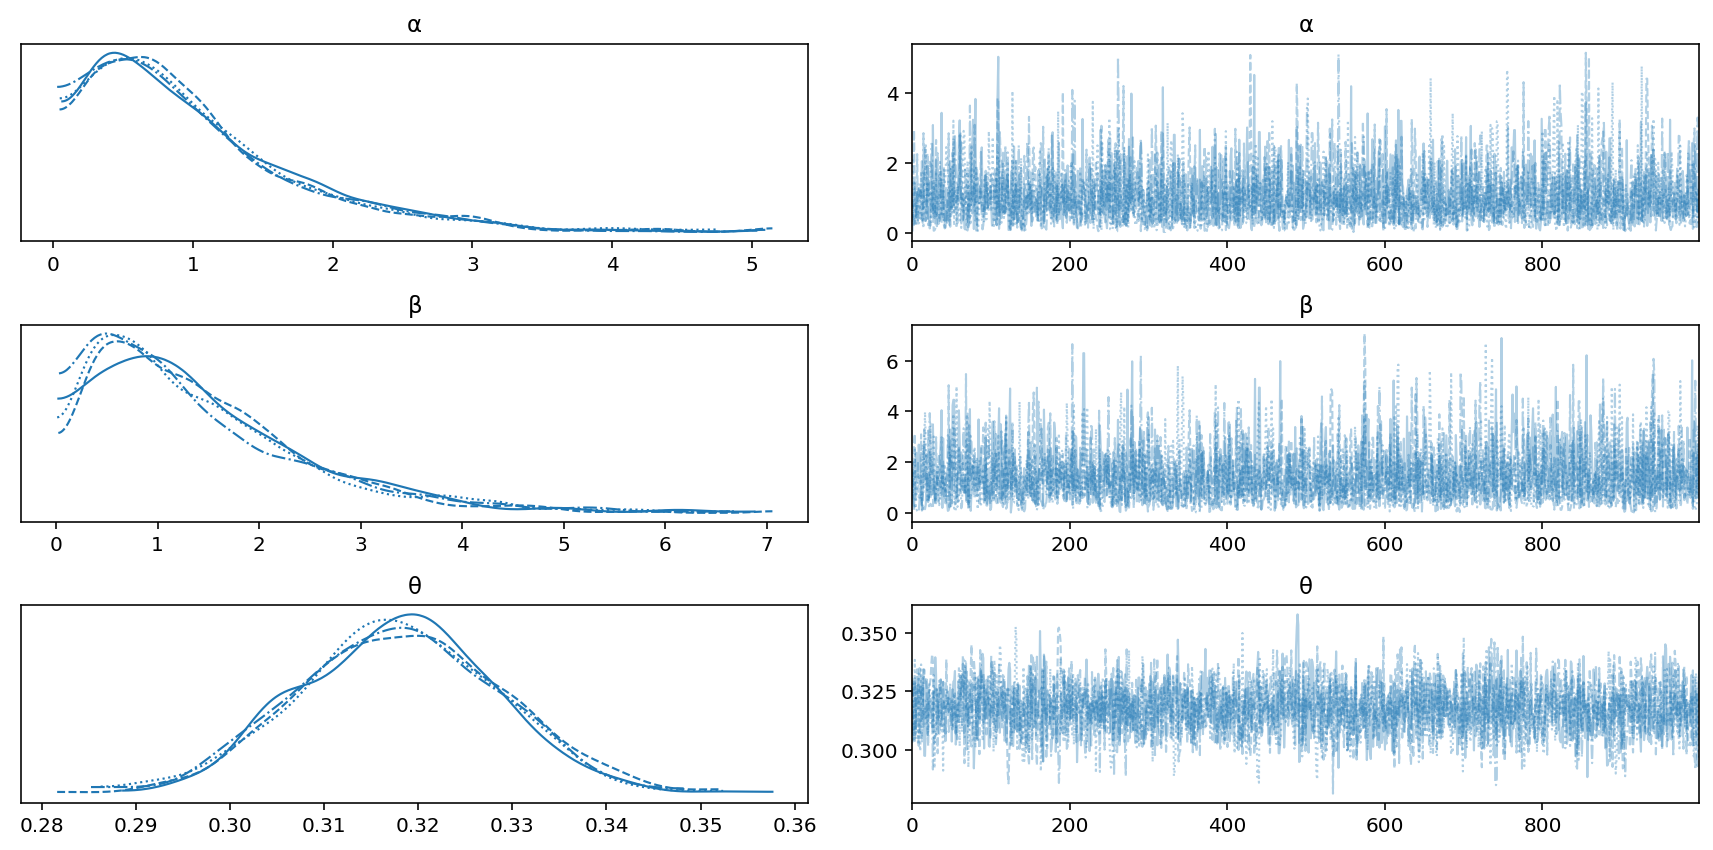

In [13]:
az.plot_trace(idata);
plt.tight_layout()

## TODO: Summary
SUMMARISE THINGS HERE. Include a correct interpretation of the model.

## WILL NOT DO
Will not extend this model beyond a single churn rate parameter $\theta$ in this notebook. That would be dealt with in a different notebook which extends the sBG model.

## References
- X
- Y
- Z